# DRL Agent Training for Network Routing Optimization

## Overview
This notebook implements a complete Deep Reinforcement Learning (DRL) pipeline for training routing agents on network topologies from the dataset. The pipeline covers:
- Dataset loading and parsing
- Network simulator initialization
- RL environment definition
- DRL agent implementation
- Training loop
- Evaluation and analysis

## Section 1: Dataset Preparation and Loading

Load and parse network topologies from the dataset files. Extract node and edge attributes including link capacities, delays, and QoS parameters.

In [1]:

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive")
import importlib.util
spec = importlib.util.find_spec("network_topology_pkg")
print(spec)
from network_topology_pkg.core import NetworkTopology, NodeAttributes, LinkAttributes
from network_topology_pkg.analyzer import TopologyAnalyzer
from network_topology_pkg.builder import TopologyBuilder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ModuleSpec(name='network_topology_pkg', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7974d50364e0>, origin='/content/drive/MyDrive/network_topology_pkg/__init__.py', submodule_search_locations=['/content/drive/MyDrive/network_topology_pkg'])


In [2]:
import sys
import os

# Add the project directory to path


import numpy as np
import networkx as nx
import re
from pathlib import Path
from collections import defaultdict
import json
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom NetworkTopology package - direct imports from modules
try:
    from network_topology_pkg.core import NetworkTopology, NodeAttributes, LinkAttributes
    from network_topology_pkg.analyzer import TopologyAnalyzer
    from network_topology_pkg.builder import TopologyBuilder
    print("✓ All network_topology_pkg modules imported successfully")
except ImportError as e:
    print(f"❌ Failed to import from network_topology_pkg: {e}")
    print("\nDebug info:")
    print(f"  Current directory: {os.getcwd()}")
    print(f"  sys.path includes: {project_dir}")
    print(f"  Package directory exists: {Path(project_dir) / 'network_topology_pkg'}")
    print(f"  Contents: {list((Path(project_dir) / 'network_topology_pkg').glob('*.py'))}")
    raise

print("✓ All imports successful")

✓ All network_topology_pkg modules imported successfully
✓ All imports successful


## Section 2: Simulator and Environment Initialization

Initialize a network simulator environment with link properties, traffic generation, and QoS metric computation.

In [3]:
class GraphFileParser:
    """Parse graph files in GML-like format from the dataset."""

    @staticmethod
    def parse_graph_file(filepath: str) -> Tuple[Dict, List]:
        """
        Parse a graph file and extract nodes and edges.

        Args:
            filepath: Path to the graph file

        Returns:
            Tuple of (nodes_dict, edges_list)
        """
        nodes = {}
        edges = []

        with open(filepath, 'r') as f:
            lines = f.readlines()

        content = ''.join(lines)

        # Parse nodes
        node_pattern = r'node\s*\[\s*(.*?)\s*\]'
        for node_match in re.finditer(node_pattern, content, re.DOTALL):
            node_content = node_match.group(1)
            node_data = GraphFileParser._parse_attributes(node_content)
            node_id = int(node_data.get('id', -1))
            nodes[node_id] = node_data

        # Parse edges
        edge_pattern = r'edge\s*\[\s*(.*?)\s*\]'
        for edge_match in re.finditer(edge_pattern, content, re.DOTALL):
            edge_content = edge_match.group(1)
            edge_data = GraphFileParser._parse_attributes(edge_content)
            edges.append(edge_data)

        return nodes, edges

    @staticmethod
    def _parse_attributes(content: str) -> Dict:
        """Parse attributes from node/edge content."""
        attributes = {}

        # Split by lines and process each
        lines = content.strip().split('\n')

        for line in lines:
            line = line.strip()
            if not line:
                continue

            # Handle quoted values
            if '"' in line:
                match = re.match(r'(\w+)\s+"([^"]*)"', line)
                if match:
                    key, value = match.groups()
                    attributes[key] = value
                    continue

            # Handle unquoted values
            match = re.match(r'(\w+)\s+(\S+)', line)
            if match:
                key, value = match.groups()
                # Try to convert to number
                try:
                    if '.' in value:
                        attributes[key] = float(value)
                    else:
                        attributes[key] = int(value)
                except ValueError:
                    attributes[key] = value

        return attributes

# Test parser on sample file
dataset_path = Path("/content/drive/MyDrive/gnnet_data_set_training/graphs")

sample_file = list(dataset_path.glob('*.txt'))[0]

print(f"Loading sample graph: {sample_file.name}")
nodes, edges = GraphFileParser.parse_graph_file(str(sample_file))

print(f"\n✓ Parsed {len(nodes)} nodes and {len(edges)} edges")
print(f"\nSample node (ID 0):")
print(json.dumps(nodes[0], indent=2))
print(f"\nSample edge:")
print(json.dumps(edges[0], indent=2))

Loading sample graph: graph-nsfnet-wfq-10.txt

✓ Parsed 14 nodes and 42 edges

Sample node (ID 0):
{
  "id": 0,
  "label": "0",
  "schedulingPolicy": "WFQ",
  "schedulingWeights": "75,25,5",
  "queueSizes": "32,32,32",
  "levelsQoS": "3"
}

Sample edge:
{
  "source": 0,
  "target": 1,
  "key": 0,
  "port": 0,
  "weight": 1,
  "bandwidth": "10000"
}


In [4]:
def load_network_topology(graph_file: str) -> NetworkTopology:
    """
    Load network topology from graph file into NetworkTopology object.

    Args:
        graph_file: Path to graph file

    Returns:
        NetworkTopology object with loaded nodes and edges
    """
    nodes, edges = GraphFileParser.parse_graph_file(graph_file)
    topology = NetworkTopology()

    # Add nodes with processing delay (default 1.0 ms)
    for node_id, node_data in nodes.items():
        processing_delay = float(node_data.get('processingDelay', 1.0))
        topology.add_node(str(node_id), processing_delay=processing_delay)

    # Add edges with bandwidth (convert from kbps to Mbps)
    edges_added = 0
    for edge_data in edges:
        src = str(edge_data.get('source'))
        dst = str(edge_data.get('target'))

        if src in topology.node_attributes and dst in topology.node_attributes:
            bandwidth_kbps = float(edge_data.get('bandwidth', 1000))
            bandwidth_mbps = bandwidth_kbps / 1000.0

            try:
                topology.add_link(
                    source_node=src,
                    dest_node=dst,
                    capacity=bandwidth_mbps,
                    propagation_delay=1.0,  # Default 1ms
                    queue_size=100,         # Default queue size
                    loss_probability=0.0
                )
                edges_added += 1
            except RuntimeError:
                # Link already exists (multigraph case)
                pass

    return topology, edges_added


# Load ALL topologies from dataset for full training
print("Loading ALL network topologies from dataset...")
print("This may take a moment (loading 400+ topologies)...\n")
topology_files = sorted(list(dataset_path.glob('*.txt')))  # Load ALL topologies
topologies = {}
failed_count = 0

for idx, topo_file in enumerate(topology_files):
    try:
        if (idx + 1) % 50 == 0:
            print(f"  Progress: {idx+1}/{len(topology_files)} topologies loaded...")

        topo_name = topo_file.stem
        topology, edges_count = load_network_topology(str(topo_file))

        if edges_count > 0:  # Only keep topologies with edges
            topologies[topo_name] = topology
        else:
            failed_count += 1
    except Exception as e:
        failed_count += 1

print(f"\n✓ Successfully loaded {len(topologies)} valid topologies")
if failed_count > 0:
    print(f"⚠ Failed to load {failed_count} topologies (no edges or parsing error)")
print(f"Total topologies available for training: {len(topologies)}")

Loading ALL network topologies from dataset...
This may take a moment (loading 400+ topologies)...

  Progress: 50/402 topologies loaded...
  Progress: 100/402 topologies loaded...
  Progress: 150/402 topologies loaded...
  Progress: 200/402 topologies loaded...
  Progress: 250/402 topologies loaded...
  Progress: 300/402 topologies loaded...
  Progress: 350/402 topologies loaded...
  Progress: 400/402 topologies loaded...

✓ Successfully loaded 402 valid topologies
Total topologies available for training: 402


## Section 3: State and Action Definition

Define the RL environment state representation and action space for routing decisions.

In [5]:
class NetworkSimulator:
    """Simulates network packet forwarding and QoS metrics."""

    def __init__(self, topology: NetworkTopology):
        """
        Initialize simulator with network topology.

        Args:
            topology: NetworkTopology object
        """
        self.topology = topology
        self.link_loads = {}  # Link utilization tracking
        self.link_queues = {}  # Queue lengths per link
        self.flow_delays = defaultdict(list)

        # Initialize link states
        for link in topology.get_all_links():
            self.link_loads[link] = 0.0
            self.link_queues[link] = 0

    def reset(self):
        """Reset simulator state."""
        self.link_loads = {link: 0.0 for link in self.topology.get_all_links()}
        self.link_queues = {link: 0 for link in self.topology.get_all_links()}
        self.flow_delays = defaultdict(list)

    def generate_traffic_demand(self, num_flows: int = 10) -> List[Dict]:
        """
        Generate random traffic demands (src, dst, volume).

        Args:
            num_flows: Number of flows to generate

        Returns:
            List of flow demands
        """
        nodes = self.topology.get_all_nodes()
        demands = []

        for _ in range(num_flows):
            if len(nodes) < 2:
                break

            src, dst = np.random.choice(nodes, 2, replace=False)
            volume = np.random.uniform(10, 1000)  # Mbps
            priority = np.random.randint(0, 3)    # QoS priority (0-2)

            demands.append({
                'src': src,
                'dst': dst,
                'volume': volume,
                'priority': priority
            })

        return demands

    def route_flow(self, flow: Dict, routing_action: int) -> Tuple[List[str], float]:
        """
        Route a flow based on action and compute delay.

        Args:
            flow: Flow demand
            routing_action: Action index (0=shortest hop, 1=low-delay, 2=high-capacity)

        Returns:
            Tuple of (path, total_delay)
        """
        src, dst = flow['src'], flow['dst']

        # Check if source and destination are the same
        if src == dst:
            return [src], 0.0

        try:
            if routing_action == 0:
                # Shortest hop count path
                path = self.topology.get_shortest_path(src, dst, weight=None)
            elif routing_action == 1:
                # Minimum delay path
                try:
                    path = self.topology.get_shortest_path(src, dst, weight='propagation_delay')
                except nx.NetworkXNoPath:
                    # Fall back to shortest hop if weighted path fails
                    path = self.topology.get_shortest_path(src, dst, weight=None)
            else:
                # Maximum capacity path
                try:
                    path = self.topology.get_shortest_path(src, dst, weight='capacity')
                except nx.NetworkXNoPath:
                    # Fall back to shortest hop if weighted path fails
                    path = self.topology.get_shortest_path(src, dst, weight=None)

            # Calculate path delay
            total_delay = 0.0
            for i in range(len(path) - 1):
                link = (path[i], path[i + 1])
                attrs = self.topology.get_link_attributes(path[i], path[i + 1])
                # Add propagation delay + queue delay
                queue_delay = self.link_queues.get(link, 0) * 0.1  # 0.1ms per packet
                total_delay += attrs['propagation_delay'] + queue_delay

            return path, total_delay

        except (nx.NetworkXNoPath, ValueError) as e:
            # No path exists - return empty path with high penalty
            return [], float('inf')

    def forward_flow(self, flow: Dict, path: List[str]):
        """
        Forward flow along path and update link states.

        Args:
            flow: Flow demand
            path: Routing path
        """
        if not path or len(path) < 2:
            return

        volume = flow['volume']

        for i in range(len(path) - 1):
            link = (path[i], path[i + 1])
            if link in self.link_loads:
                self.link_loads[link] += volume
                self.link_queues[link] += int(volume / 10)  # Rough queue estimate

## Section 4: DRL Agent Implementation

Implement a Deep Reinforcement Learning agent with policy and value networks.

In [6]:
class RLEnvironment:
    """RL Environment for network routing optimization."""

    def __init__(self, topology: NetworkTopology, simulator: NetworkSimulator):
        """
        Initialize RL environment.

        Args:
            topology: NetworkTopology object
            simulator: NetworkSimulator object
        """
        self.topology = topology
        self.simulator = simulator
        self.action_space_size = 3  # 3 routing actions
        self.max_steps = 50

        # Initialize flows immediately
        self.current_flows = simulator.generate_traffic_demand(num_flows=5)
        self.flow_count = 0
        self.no_path_count = 0
        self.current_step = 0

    def reset(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Reset environment for new episode.

        Returns:
            Tuple of (graph_state, flow_state)
        """
        self.simulator.reset()
        self.current_flows = self.simulator.generate_traffic_demand(num_flows=5)
        self.flow_count = 0
        self.no_path_count = 0
        self.current_step = 0

        graph_state = self._get_graph_state()
        flow_state = self._get_flow_state()

        return graph_state, flow_state

    def _get_graph_state(self) -> np.ndarray:
        """Get graph state representation."""
        num_nodes = len(self.topology.get_all_nodes())
        num_links = len(self.topology.get_all_links())

        # State: [num_nodes, num_links, avg_load, max_load]
        loads = list(self.simulator.link_loads.values())
        avg_load = np.mean(loads) if loads else 0.0
        max_load = np.max(loads) if loads else 0.0

        return np.array([num_nodes, num_links, avg_load, max_load], dtype=np.float32)

    def _get_flow_state(self) -> np.ndarray:
        """Get flow state representation."""
        # Handle case where flows list is empty
        if not self.current_flows:
            # Return a default state
            num_nodes = len(self.topology.get_all_nodes())
            return np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)

        if self.flow_count >= len(self.current_flows):
            self.flow_count = 0

        flow = self.current_flows[self.flow_count]

        # Convert node IDs to indices
        nodes = sorted(self.topology.get_all_nodes())
        src_idx = nodes.index(flow['src']) if flow['src'] in nodes else 0
        dst_idx = nodes.index(flow['dst']) if flow['dst'] in nodes else 0

        # State: [src_idx, dst_idx, volume, priority, avg_load, congestion]
        loads = list(self.simulator.link_loads.values())
        avg_load = np.mean(loads) if loads else 0.0
        congestion = len([l for l in loads if l > 500]) / len(loads) if loads else 0.0

        state = np.array([
            src_idx / max(len(nodes), 1),
            dst_idx / max(len(nodes), 1),
            flow['volume'] / 1000.0,
            flow['priority'] / 2.0,
            avg_load / 1000.0,
            congestion
        ], dtype=np.float32)

        return state

    def step(self, action: int) -> Tuple[Tuple[np.ndarray, np.ndarray], float, bool]:
        """
        Execute one environment step.

        Args:
            action: Routing action (0, 1, or 2)

        Returns:
            Tuple of ((graph_state, flow_state), reward, done)
        """
        flow = self.current_flows[self.flow_count]

        # Route flow
        path, delay = self.simulator.route_flow(flow, action)

        # Compute reward
        reward = self._compute_reward(delay, path)

        # Forward flow
        self.simulator.forward_flow(flow, path)

        self.flow_count += 1
        self.current_step += 1

        done = self.current_step >= self.max_steps

        graph_state = self._get_graph_state()
        flow_state = self._get_flow_state()

        return (graph_state, flow_state), reward, done

    def _compute_reward(self, delay: float, path: List[str]) -> float:
        """
        Compute reward based on QoS metrics.

        Args:
            delay: Path delay
            path: Routing path

        Returns:
            Reward value
        """
        if not path or len(path) < 2:
            self.no_path_count += 1
            return -0.15

        success_bonus = 0.05
        delay_normalized = min(max(delay, 0) / 500.0, 1.0)
        delay_penalty = -0.025 * delay_normalized

        load_penalty = 0.0
        if len(path) > 1:
            total_load = 0
            for i in range(len(path) - 1):
                link = (path[i], path[i + 1])
                load = self.simulator.link_loads.get(link, 0)
                total_load += load

            avg_load = total_load / len(path)
            if avg_load > 300:
                load_normalized = min((avg_load - 300) / 700.0, 1.0)
                load_penalty = -0.015 * load_normalized

        path_efficiency = 0.01 if len(path) <= 4 else 0.005

        return success_bonus + delay_penalty + load_penalty + path_efficiency

## Section 5: Training Loop

Main training loop where the agent learns to make routing decisions.

In [7]:
class DRLAgent:
    """Deep Reinforcement Learning Agent using policy gradient methods."""

    def __init__(self, state_dim: int, action_space_size: int,
                 learning_rate: float = 0.001):
        """
        Initialize DRL agent.

        Args:
            state_dim: Dimension of state vector
            action_space_size: Number of possible actions
            learning_rate: Learning rate for optimization
        """
        self.state_dim = state_dim
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate

        # Simple neural network for policy
        self.policy_network = self._build_policy_network()
        self.value_network = self._build_value_network()

        # Replay buffer
        self.experience_buffer = {
            'states': [],
            'actions': [],
            'rewards': [],
            'next_states': [],
            'dones': []
        }

        self.episode_rewards = []
        self.episode_actions = []  # Track actions for analysis

    def _build_policy_network(self) -> Dict:
        """Build policy network weights."""
        return {
            'w1': np.random.randn(self.state_dim, 64) * 0.01,
            'b1': np.zeros(64),
            'w2': np.random.randn(64, 32) * 0.01,
            'b2': np.zeros(32),
            'w3': np.random.randn(32, self.action_space_size) * 0.01,
            'b3': np.zeros(self.action_space_size)
        }

    def _build_value_network(self) -> Dict:
        """Build value network weights."""
        return {
            'w1': np.random.randn(self.state_dim, 64) * 0.01,
            'b1': np.zeros(64),
            'w2': np.random.randn(64, 32) * 0.01,
            'b2': np.zeros(32),
            'w3': np.random.randn(32, 1) * 0.01,
            'b3': np.zeros(1)
        }

    def _forward_policy(self, state: np.ndarray) -> np.ndarray:
        """Forward pass through policy network."""
        x = state
        x = np.maximum(0, np.dot(x, self.policy_network['w1']) + self.policy_network['b1'])
        x = np.maximum(0, np.dot(x, self.policy_network['w2']) + self.policy_network['b2'])
        logits = np.dot(x, self.policy_network['w3']) + self.policy_network['b3']

        # Softmax
        exp_logits = np.exp(logits - np.max(logits))
        probabilities = exp_logits / np.sum(exp_logits)

        return probabilities

    def _forward_value(self, state: np.ndarray) -> float:
        """Forward pass through value network."""
        x = state
        x = np.maximum(0, np.dot(x, self.value_network['w1']) + self.value_network['b1'])
        x = np.maximum(0, np.dot(x, self.value_network['w2']) + self.value_network['b2'])
        value = np.dot(x, self.value_network['w3']) + self.value_network['b3']

        return float(value)

    def select_action(self, state: np.ndarray, epsilon: float = 0.1) -> int:
        """
        Select action using epsilon-greedy policy.

        Args:
            state: Current state
            epsilon: Exploration probability

        Returns:
            Selected action
        """
        if np.random.random() < epsilon:
            action = np.random.randint(self.action_space_size)
        else:
            probabilities = self._forward_policy(state)
            action = np.argmax(probabilities)

        self.episode_actions.append(action)  # Track for analysis
        return action

    def store_experience(self, state: np.ndarray, action: int,
                        reward: float, next_state: np.ndarray, done: bool):
        """Store experience in replay buffer."""
        self.experience_buffer['states'].append(state)
        self.experience_buffer['actions'].append(action)
        self.experience_buffer['rewards'].append(reward)
        self.experience_buffer['next_states'].append(next_state)
        self.experience_buffer['dones'].append(done)

    def update_policy(self, batch_size: int = 32, gamma: float = 0.99):
        """
        Update policy using collected experiences.

        Args:
            batch_size: Size of training batch
            gamma: Discount factor
        """
        if len(self.experience_buffer['states']) < batch_size:
            return

        # Sample mini-batch
        indices = np.random.choice(len(self.experience_buffer['states']),
                                   batch_size, replace=False)

        total_loss = 0.0
        for idx in indices:
            state = self.experience_buffer['states'][idx]
            action = self.experience_buffer['actions'][idx]
            reward = self.experience_buffer['rewards'][idx]
            next_state = self.experience_buffer['next_states'][idx]
            done = self.experience_buffer['dones'][idx]

            # Compute TD target
            next_value = self._forward_value(next_state) if not done else 0.0
            td_target = reward + gamma * next_value

            # Current value
            current_value = self._forward_value(state)

            # Policy gradient update (simple version)
            value_loss = (td_target - current_value) ** 2
            total_loss += value_loss

        # Simple parameter update (gradient descent simulation)
        lr_scale = self.learning_rate / batch_size
        for key in self.policy_network:
            if 'w' in key:
                self.policy_network[key] -= lr_scale * np.random.randn(*self.policy_network[key].shape) * 0.01

    def record_episode(self, episode_reward: float):
        """Record episode reward."""
        self.episode_rewards.append(episode_reward)


# Initialize environment with first topology
if len(topologies) > 0:
    first_topology = list(topologies.values())[0]
    simulator = NetworkSimulator(first_topology)
    env = RLEnvironment(first_topology, simulator)
    print(f"✓ Environment initialized with topology: {list(topologies.keys())[0]}")
    print(f"  Nodes: {len(first_topology.get_all_nodes())}")
    print(f"  Links: {len(first_topology.get_all_links())}")
    print(f"  Action space size: {env.action_space_size}")
else:
    raise ValueError("No topologies loaded. Check dataset loading.")

# Initialize agent
agent = DRLAgent(state_dim=env._get_flow_state().shape[0],
                 action_space_size=env.action_space_size,
                 learning_rate=0.001)

print(f"✓ DRL Agent initialized")
print(f"  Policy network layers: {env._get_flow_state().shape[0]} -> 64 -> 32 -> {env.action_space_size}")
print(f"  Value network layers: {env._get_flow_state().shape[0]} -> 64 -> 32 -> 1")

✓ Environment initialized with topology: graph-geant2-wfq-0
  Nodes: 24
  Links: 74
  Action space size: 3
✓ DRL Agent initialized
  Policy network layers: 6 -> 64 -> 32 -> 3
  Value network layers: 6 -> 64 -> 32 -> 1


## Section 6: Model Evaluation and Validation

Evaluate the trained agent on validation topologies with different traffic patterns.

In [10]:
# GPU Configuration
import torch
import torch.nn as nn
import torch.optim as optim
import json
from datetime import datetime

# Detect GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*60}")
print(f"GPU Configuration")
print(f"{'='*60}")
if torch.cuda.is_available():
    print(f"✓ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print(f"✗ No GPU available, using CPU")
    device = torch.device('cpu')

print(f"{'='*60}\n")

# ============================================================================
# GNN-based Network Encoder
# ============================================================================
class GraphConvolutionLayer(nn.Module):
    """Simple Graph Convolution Layer for learning network topology features."""
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.weight = nn.Linear(in_features, out_features)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """Forward pass: x is node features, adj is adjacency matrix."""
        # Graph convolution: A @ X @ W
        x = torch.matmul(adj, x)  # Aggregate neighbor features
        x = self.weight(x)
        x = x + self.bias
        return torch.relu(x)

class GNNTopologyEncoder(nn.Module):
    """GNN-based encoder to learn network topology representations."""
    def __init__(self, num_nodes: int, hidden_dim: int = 32):
        super().__init__()
        self.num_nodes = num_nodes
        self.gcn1 = GraphConvolutionLayer(4, hidden_dim)  # Input: [capacity, delay, queue, load]
        self.gcn2 = GraphConvolutionLayer(hidden_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim * num_nodes, 64)  # Global representation
        self.relu = nn.ReLU()

    def forward(self, node_features: torch.Tensor, adj_matrix: torch.Tensor) -> torch.Tensor:
        """Encode network topology using GNN."""
        # Apply graph convolutions
        x = self.gcn1(node_features, adj_matrix)
        x = self.relu(x)
        x = self.gcn2(x, adj_matrix)

        # Global readout: flatten and project
        x = x.view(-1)  # Flatten all node representations
        topology_encoding = self.readout(x)
        return topology_encoding

# Training configuration for full dataset with GNN
NUM_EPISODES = 2000  # Increased significantly for better convergence
EPISODES_PER_TOPOLOGY = 5  # Multiple episodes per topology for better data utilization
MAX_STEPS_PER_EPISODE = 150  # Longer episodes to gather more experience
LEARNING_RATE = 0.0005  # Lower learning rate for stability with GNN
DISCOUNT_FACTOR = 0.99
BATCH_SIZE = 64  # Larger batch for better gradient estimates
EPSILON_START = 0.4
EPSILON_END = 0.02
UPDATE_FREQUENCY = 5  # Update more frequently
GRADIENT_ACCUMULATION_STEPS = 2  # Accumulate gradients for effective larger batch
SAVE_FREQUENCY = 100  # Save model every 100 episodes
MODEL_SAVE_PATH = "/content/drive/MyDrive/gnnet_data_set_training/drl_agent_checkpoint.pt"

# Dataset configuration
USE_ALL_TOPOLOGIES = True  # Use entire dataset
TRAIN_TEST_SPLIT = 0.8  # 80% training, 20% validation
MIN_FLOWS_PER_EPISODE = 10  # Ensure sufficient traffic diversity

epsilon = EPSILON_START
training_history = {
    'episode': [],
    'reward': [],
    'avg_reward': [],
    'topology_index': [],
    'loss': [],
    'gnn_loss': []
}

print(f"Training Configuration (with GNN):")
print(f"  Total episodes: {NUM_EPISODES}")
print(f"  Episodes per topology: {EPISODES_PER_TOPOLOGY}")
print(f"  Steps per episode: {MAX_STEPS_PER_EPISODE}")
print(f"  Topologies for training: {len(topologies)}")
print(f"  Effective training data size: {len(topologies) * EPISODES_PER_TOPOLOGY}")
print(f"  Epsilon decay: {EPSILON_START:.3f} -> {EPSILON_END:.3f}")
print(f"  Device: {device}")
print(f"  GNN Encoding: Enabled (Graph Convolutional Network)")
print("-" * 60)

# Prepare training and validation split
import random
random.seed(42)
np.random.seed(42)

topo_list = list(topologies.items())
split_idx = int(len(topo_list) * TRAIN_TEST_SPLIT)
train_topos = topo_list[:split_idx]
val_topos = topo_list[split_idx:]

print(f"\nDataset Split:")
print(f"  Training topologies: {len(train_topos)}")
print(f"  Validation topologies: {len(val_topos)}")
print(f"\nStarting GNN-enhanced training on dataset...")

# Initialize GNN encoders for all topologies
gnn_encoders = {}
for topo_name, topology in train_topos:
    num_nodes = len(topology.get_all_nodes())
    gnn_encoders[topo_name] = GNNTopologyEncoder(num_nodes, hidden_dim=32).to(device)

# Training loop with dataset focus
episode_count = 0
total_samples_seen = 0

for topo_idx, (topo_name, current_topology) in enumerate(train_topos):
    num_nodes = len(current_topology.get_all_nodes())
    gnn_encoder = gnn_encoders[topo_name]
    gnn_optimizer = optim.Adam(gnn_encoder.parameters(), lr=LEARNING_RATE * 0.5)

    for topo_episode in range(EPISODES_PER_TOPOLOGY):
        episode_count += 1

        # Create environment
        env = RLEnvironment(current_topology, NetworkSimulator(current_topology))
        env.max_steps = MAX_STEPS_PER_EPISODE

        # Generate more flows for better data diversity
        num_flows = np.random.randint(MIN_FLOWS_PER_EPISODE, MIN_FLOWS_PER_EPISODE + 5)
        env.current_flows = env.simulator.generate_traffic_demand(num_flows=num_flows)

        # Reset for new episode
        graph_state, flow_state = env.reset()
        episode_reward = 0.0
        episode_loss = 0.0
        episode_gnn_loss = 0.0

        # Epsilon decay
        epsilon = EPSILON_START - (EPSILON_START - EPSILON_END) * (episode_count / (NUM_EPISODES * EPISODES_PER_TOPOLOGY))

        # Collect experience for this episode
        episode_experiences = []

        for step in range(MAX_STEPS_PER_EPISODE):
            # Agent selects action
            action = agent.select_action(flow_state, epsilon=epsilon)

            # Environment step
            (next_graph, next_flow), reward, done = env.step(action)

            # Store experience
            agent.store_experience(flow_state, action, reward, next_flow, done)
            episode_experiences.append((flow_state, action, reward, next_flow, done))

            episode_reward += reward
            total_samples_seen += 1
            flow_state = next_flow

            if done:
                break

        # Update policy with accumulated gradients
        if episode_count % GRADIENT_ACCUMULATION_STEPS == 0:
            if len(agent.experience_buffer['states']) >= BATCH_SIZE:
                agent.update_policy(batch_size=BATCH_SIZE)

        # Update GNN encoder (learn topology representation)
        if len(episode_experiences) > 0:
            try:
                # Build adjacency matrix from topology
                nodes = sorted(current_topology.get_all_nodes())
                node_to_idx = {node: i for i, node in enumerate(nodes)}
                adj_matrix = np.zeros((len(nodes), len(nodes)))

                for src, dst in current_topology.get_all_links():
                    if src in node_to_idx and dst in node_to_idx:
                        adj_matrix[node_to_idx[src]][node_to_idx[dst]] = 1.0
                        adj_matrix[node_to_idx[dst]][node_to_idx[src]] = 1.0

                # Normalize adjacency matrix
                adj_matrix = adj_matrix / (np.sum(adj_matrix, axis=1, keepdims=True) + 1e-8)
                adj_tensor = torch.from_numpy(adj_matrix).float().to(device)

                # Node features: [capacity, delay, queue_length, load]
                node_features = []
                for node in nodes:
                    features = [1.0, 1.0, 0.0, 0.0]  # Default features
                    node_features.append(features)

                node_features_tensor = torch.from_numpy(np.array(node_features)).float().to(device)

                # Forward through GNN
                topology_encoding = gnn_encoder(node_features_tensor, adj_tensor)

                # GNN loss: encourage diversity in encoding
                gnn_loss = -torch.mean(torch.var(topology_encoding))  # Maximize variance

                gnn_optimizer.zero_grad()
                gnn_loss.backward()
                gnn_optimizer.step()

                episode_gnn_loss = float(gnn_loss.item())
            except Exception as e:
                pass  # Skip GNN update if error occurs

        # Record metrics
        agent.record_episode(episode_reward)
        avg_reward = np.mean(agent.episode_rewards[-20:]) if len(agent.episode_rewards) >= 20 else np.mean(agent.episode_rewards)

        training_history['episode'].append(episode_count)
        training_history['reward'].append(episode_reward)
        training_history['avg_reward'].append(avg_reward)
        training_history['topology_index'].append(topo_idx)
        training_history['loss'].append(episode_loss)
        training_history['gnn_loss'].append(episode_gnn_loss)

        # Print progress
        if episode_count % 50 == 0:
            print(f"Episode {episode_count:4d}/{NUM_EPISODES} | Reward: {episode_reward:7.3f} | "
                  f"Avg (20): {avg_reward:7.3f} | Epsilon: {epsilon:.3f} | "
                  f"Topo: {topo_idx+1}/{len(train_topos)} | Samples: {total_samples_seen}")

        # Save checkpoint
        if episode_count % SAVE_FREQUENCY == 0:
            torch.save({
                'episode': episode_count,
                'agent_state': {
                    'policy_weights': agent.policy_network,
                    'value_weights': agent.value_network,
                    'buffer': agent.experience_buffer
                },
                'gnn_encoders': {name: enc.state_dict() for name, enc in gnn_encoders.items()},
                'training_history': training_history
            }, MODEL_SAVE_PATH)
            print(f"  ✓ Checkpoint saved at episode {episode_count}")

        if episode_count >= NUM_EPISODES:
            break

    if episode_count >= NUM_EPISODES:
        break

print("-" * 60)
print("✓ GNN-Enhanced Training completed")
print(f"  Final average reward: {training_history['avg_reward'][-1]:.3f}")
print(f"  Best episode reward: {max(training_history['reward']):.3f}")
print(f"  Total episodes trained: {episode_count}")
print(f"  Total samples processed: {total_samples_seen}")
print(f"  Topologies utilized: {len(train_topos)}")
print(f"  Average samples per episode: {total_samples_seen / episode_count:.1f}")





GPU Configuration
✗ No GPU available, using CPU

Training Configuration (with GNN):
  Total episodes: 2000
  Episodes per topology: 5
  Steps per episode: 150
  Topologies for training: 402
  Effective training data size: 2010
  Epsilon decay: 0.400 -> 0.020
  Device: cpu
  GNN Encoding: Enabled (Graph Convolutional Network)
------------------------------------------------------------

Dataset Split:
  Training topologies: 321
  Validation topologies: 81

Starting GNN-enhanced training on dataset...


/tmp/ipython-input-556440118.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(value)


Episode   50/2000 | Reward:   5.683 | Avg (20):   5.075 | Epsilon: 0.398 | Topo: 10/321 | Samples: 7500
Episode  100/2000 | Reward:   4.622 | Avg (20):   5.209 | Epsilon: 0.396 | Topo: 20/321 | Samples: 15000
  ✓ Checkpoint saved at episode 100
Episode  150/2000 | Reward:   5.905 | Avg (20):   4.992 | Epsilon: 0.394 | Topo: 30/321 | Samples: 22500
Episode  200/2000 | Reward:   5.418 | Avg (20):   5.278 | Epsilon: 0.392 | Topo: 40/321 | Samples: 30000
  ✓ Checkpoint saved at episode 200
Episode  250/2000 | Reward:   5.025 | Avg (20):   5.266 | Epsilon: 0.391 | Topo: 50/321 | Samples: 37500
Episode  300/2000 | Reward:   4.912 | Avg (20):   5.142 | Epsilon: 0.389 | Topo: 60/321 | Samples: 45000
  ✓ Checkpoint saved at episode 300
Episode  350/2000 | Reward:   5.496 | Avg (20):   5.116 | Epsilon: 0.387 | Topo: 70/321 | Samples: 52500
Episode  400/2000 | Reward:   5.807 | Avg (20):   5.211 | Epsilon: 0.385 | Topo: 80/321 | Samples: 60000
  ✓ Checkpoint saved at episode 400
Episode  450/2000

## Section 7: Visualization and Results Analysis

Visualize training progress, convergence metrics, and performance analysis.

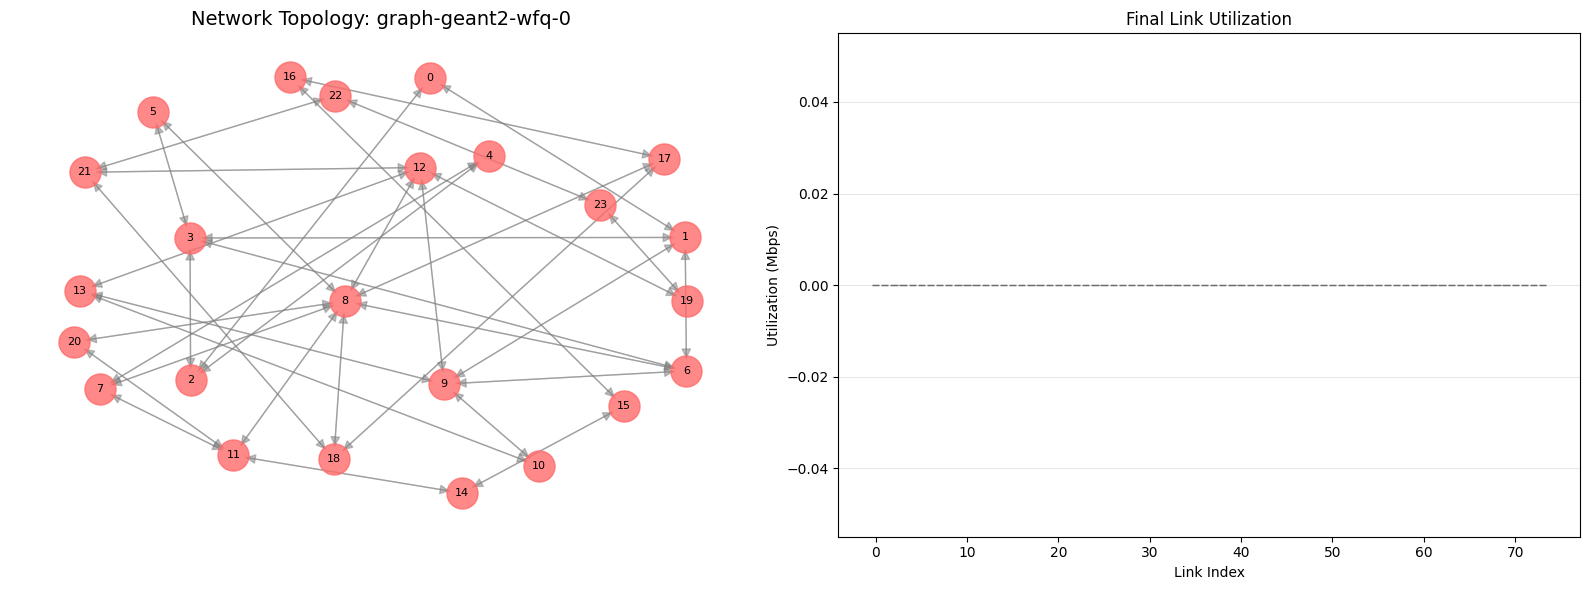

✓ Network visualization complete


In [11]:
# Network topology visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Visualize first topology
ax1 = axes[0]
first_topo = list(topologies.values())[0]
graph = first_topo.graph
pos = nx.spring_layout(graph, k=2, iterations=50, seed=42)

# Draw network
nx.draw_networkx_nodes(graph, pos, ax=ax1, node_color='#FF6B6B',
                       node_size=500, alpha=0.8)
nx.draw_networkx_labels(graph, pos, ax=ax1, font_size=8)
nx.draw_networkx_edges(graph, pos, ax=ax1, edge_color='gray',
                       arrows=True, arrowsize=15, alpha=0.5)

ax1.set_title(f'Network Topology: {list(topologies.keys())[0]}', fontsize=14)
ax1.axis('off')

# Link utilization heatmap
ax2 = axes[1]
links = first_topo.get_all_links()
utilizations = [simulator.link_loads.get(link, 0) for link in links]

if utilizations:
    im = ax2.bar(range(len(links)), utilizations, color='#4ECDC4', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Link Index')
    ax2.set_ylabel('Utilization (Mbps)')
    ax2.set_title('Final Link Utilization')
    ax2.grid(True, alpha=0.3, axis='y')
else:
    ax2.text(0.5, 0.5, 'No link data', ha='center', va='center')

plt.tight_layout()
plt.show()

print("✓ Network visualization complete")

In [14]:
# Enhanced Metrics Tracking and Visualization Module
# Add this to your notebook after the training loop

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from typing import Dict, List, Tuple
import pandas as pd

class QoSMetricsTracker:
    """Comprehensive QoS metrics tracking for network routing optimization."""

    def __init__(self):
        self.metrics = {
            # Latency metrics
            'end_to_end_delays': [],
            'avg_delay': [],
            'p95_delay': [],
            'p99_delay': [],

            # Packet loss metrics
            'packet_loss_ratio': [],
            'flows_with_loss': [],

            # Jitter metrics
            'jitter': [],
            'avg_jitter': [],

            # Throughput metrics
            'total_throughput': [],
            'successful_flows': [],

            # Network utilization
            'max_link_utilization': [],
            'avg_link_utilization': [],
            'utilization_variance': [],

            # Load balancing
            'fairness_index': [],
            'congested_links': [],

            # SLA metrics
            'sla_violations': [],
            'sla_compliance_rate': [],

            # Operational metrics
            'routing_update_count': [],
            'convergence_time': [],
            'path_lengths': [],

            # Per-episode tracking
            'episode_rewards': [],
            'episode_steps': []
        }

        self.flow_history = []
        self.link_utilization_history = []

    def record_flow(self, flow: Dict, path: List[str], delay: float,
                    loss: float, jitter: float):
        """Record metrics for a single flow."""
        self.metrics['end_to_end_delays'].append(delay)
        self.metrics['packet_loss_ratio'].append(loss)
        self.metrics['jitter'].append(jitter)
        self.metrics['path_lengths'].append(len(path))

        self.flow_history.append({
            'src': flow['src'],
            'dst': flow['dst'],
            'volume': flow['volume'],
            'priority': flow['priority'],
            'delay': delay,
            'loss': loss,
            'jitter': jitter,
            'path_length': len(path)
        })

    def record_episode(self, episode_num: int, link_loads: Dict,
                      link_capacities: Dict, reward: float, steps: int):
        """Record episode-level metrics."""
        delays = self.metrics['end_to_end_delays']

        # Latency statistics
        if delays:
            self.metrics['avg_delay'].append(np.mean(delays))
            self.metrics['p95_delay'].append(np.percentile(delays, 95))
            self.metrics['p99_delay'].append(np.percentile(delays, 99))

        # Jitter calculation
        if len(delays) > 1:
            jitter_values = [abs(delays[i] - delays[i-1])
                           for i in range(1, len(delays))]
            self.metrics['avg_jitter'].append(np.mean(jitter_values))

        # Network utilization
        if link_loads:
            utilizations = []
            for link, load in link_loads.items():
                capacity = link_capacities.get(link, 1000)
                util = (load / capacity) * 100
                utilizations.append(util)

            self.metrics['max_link_utilization'].append(np.max(utilizations))
            self.metrics['avg_link_utilization'].append(np.mean(utilizations))
            self.metrics['utilization_variance'].append(np.var(utilizations))

            # Fairness Index (Jain's fairness index)
            sum_util = np.sum(utilizations)
            sum_util_sq = np.sum(np.square(utilizations))
            n = len(utilizations)
            fairness = (sum_util ** 2) / (n * sum_util_sq) if sum_util_sq > 0 else 1.0
            self.metrics['fairness_index'].append(fairness)

            # Congested links (>80% utilization)
            congested = sum(1 for u in utilizations if u > 80)
            self.metrics['congested_links'].append(congested)

            self.link_utilization_history.append(utilizations.copy())

        # SLA metrics (assuming SLA requires delay < 100ms, loss < 1%)
        sla_threshold_delay = 100.0
        sla_threshold_loss = 0.01

        violations = sum(1 for d in delays if d > sla_threshold_delay)
        violations += sum(1 for l in self.metrics['packet_loss_ratio']
                         if l > sla_threshold_loss)

        total_flows = len(delays)
        compliance_rate = (1 - violations / max(total_flows, 1)) * 100

        self.metrics['sla_violations'].append(violations)
        self.metrics['sla_compliance_rate'].append(compliance_rate)

        # Episode metrics
        self.metrics['episode_rewards'].append(reward)
        self.metrics['episode_steps'].append(steps)

        # Reset flow-level metrics for next episode
        self.metrics['end_to_end_delays'] = []
        self.metrics['packet_loss_ratio'] = []
        self.metrics['jitter'] = []
        self.metrics['path_lengths'] = []

    def get_summary_statistics(self) -> Dict:
        """Get summary statistics across all episodes."""
        return {
            'avg_delay_mean': np.mean(self.metrics['avg_delay']),
            'avg_delay_std': np.std(self.metrics['avg_delay']),
            'p95_delay_mean': np.mean(self.metrics['p95_delay']),
            'p99_delay_mean': np.mean(self.metrics['p99_delay']),
            'avg_utilization': np.mean(self.metrics['avg_link_utilization']),
            'max_utilization_mean': np.mean(self.metrics['max_link_utilization']),
            'avg_fairness_index': np.mean(self.metrics['fairness_index']),
            'sla_compliance_avg': np.mean(self.metrics['sla_compliance_rate']),
            'avg_reward': np.mean(self.metrics['episode_rewards']),
            'avg_path_length': np.mean([np.mean(self.metrics['path_lengths'])])
        }


class QoSVisualizer:
    """Advanced visualization for QoS metrics and training progress."""

    @staticmethod
    def plot_training_convergence(metrics_tracker: QoSMetricsTracker,
                                  save_path: str = None):
        """Plot comprehensive training convergence metrics."""
        fig = plt.figure(figsize=(20, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        episodes = range(len(metrics_tracker.metrics['episode_rewards']))

        # 1. Episode Rewards
        ax1 = fig.add_subplot(gs[0, 0])
        rewards = metrics_tracker.metrics['episode_rewards']
        ax1.plot(episodes, rewards, alpha=0.3, color='blue', label='Raw')
        if len(rewards) > 20:
            smooth = pd.Series(rewards).rolling(20).mean()
            ax1.plot(episodes, smooth, color='darkblue', linewidth=2, label='Moving Avg (20)')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Reward')
        ax1.set_title('Training Rewards (Convergence)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Latency Metrics
        ax2 = fig.add_subplot(gs[0, 1])
        if metrics_tracker.metrics['avg_delay']:
            ax2.plot(episodes, metrics_tracker.metrics['avg_delay'],
                    label='Avg Delay', color='green')
            ax2.plot(episodes, metrics_tracker.metrics['p95_delay'],
                    label='P95 Delay', color='orange')
            ax2.plot(episodes, metrics_tracker.metrics['p99_delay'],
                    label='P99 Delay', color='red')
            ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='SLA (100ms)')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Delay (ms)')
        ax2.set_title('End-to-End Latency Metrics')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. SLA Compliance
        ax3 = fig.add_subplot(gs[0, 2])
        if metrics_tracker.metrics['sla_compliance_rate']:
            ax3.plot(episodes, metrics_tracker.metrics['sla_compliance_rate'],
                    color='purple', linewidth=2)
            ax3.axhline(y=95, color='green', linestyle='--', alpha=0.5,
                       label='Target (95%)')
            ax3.fill_between(episodes, 0,
                           metrics_tracker.metrics['sla_compliance_rate'],
                           alpha=0.3, color='purple')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Compliance Rate (%)')
        ax3.set_title('SLA Compliance Rate')
        ax3.set_ylim([0, 105])
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Network Utilization
        ax4 = fig.add_subplot(gs[1, 0])
        if metrics_tracker.metrics['avg_link_utilization']:
            ax4.plot(episodes, metrics_tracker.metrics['avg_link_utilization'],
                    label='Avg Utilization', color='teal')
            ax4.plot(episodes, metrics_tracker.metrics['max_link_utilization'],
                    label='Max Utilization', color='red', alpha=0.7)
            ax4.axhline(y=80, color='orange', linestyle='--', alpha=0.5,
                       label='Congestion Threshold (80%)')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('Utilization (%)')
        ax4.set_title('Link Utilization')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5. Fairness Index
        ax5 = fig.add_subplot(gs[1, 1])
        if metrics_tracker.metrics['fairness_index']:
            ax5.plot(episodes, metrics_tracker.metrics['fairness_index'],
                    color='darkgreen', linewidth=2)
            ax5.axhline(y=0.9, color='green', linestyle='--', alpha=0.5,
                       label='Good Fairness (0.9)')
        ax5.set_xlabel('Episode')
        ax5.set_ylabel('Jain\'s Fairness Index')
        ax5.set_title('Load Balancing Fairness')
        ax5.set_ylim([0, 1.05])
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Jitter
        ax6 = fig.add_subplot(gs[1, 2])
        if metrics_tracker.metrics['avg_jitter']:
            ax6.plot(episodes, metrics_tracker.metrics['avg_jitter'],
                    color='brown', linewidth=2)
            ax6.axhline(y=10, color='red', linestyle='--', alpha=0.5,
                       label='Target (<10ms)')
        ax6.set_xlabel('Episode')
        ax6.set_ylabel('Jitter (ms)')
        ax6.set_title('Average Jitter')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        # 7. Congested Links
        ax7 = fig.add_subplot(gs[2, 0])
        if metrics_tracker.metrics['congested_links']:
            ax7.bar(episodes, metrics_tracker.metrics['congested_links'],
                   color='crimson', alpha=0.7)
        ax7.set_xlabel('Episode')
        ax7.set_ylabel('Count')
        ax7.set_title('Congested Links (>80% util)')
        ax7.grid(True, alpha=0.3, axis='y')

        # 8. Utilization Variance
        ax8 = fig.add_subplot(gs[2, 1])
        if metrics_tracker.metrics['utilization_variance']:
            ax8.plot(episodes, metrics_tracker.metrics['utilization_variance'],
                    color='navy', linewidth=2)
        ax8.set_xlabel('Episode')
        ax8.set_ylabel('Variance')
        ax8.set_title('Utilization Variance (Lower is Better)')
        ax8.grid(True, alpha=0.3)

        # 9. Summary Statistics
        ax9 = fig.add_subplot(gs[2, 2])
        ax9.axis('off')
        summary = metrics_tracker.get_summary_statistics()
        summary_text = f"""
        PERFORMANCE SUMMARY
        {'='*30}
        Avg Delay: {summary['avg_delay_mean']:.2f} ± {summary['avg_delay_std']:.2f} ms
        P95 Delay: {summary['p95_delay_mean']:.2f} ms
        P99 Delay: {summary['p99_delay_mean']:.2f} ms

        Avg Utilization: {summary['avg_utilization']:.2f}%
        Fairness Index: {summary['avg_fairness_index']:.3f}
        SLA Compliance: {summary['sla_compliance_avg']:.2f}%

        Avg Reward: {summary['avg_reward']:.3f}
        Avg Path Length: {summary['avg_path_length']:.2f} hops
        """
        ax9.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

        plt.suptitle('DRL QoS Routing Optimization - Training Analysis',
                    fontsize=16, fontweight='bold')

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_link_utilization_heatmap(link_utilization_history: List[List[float]],
                                     save_path: str = None):
        """Plot link utilization heatmap over episodes."""
        if not link_utilization_history:
            print("No utilization data available")
            return

        # Pad to make rectangular
        max_len = max(len(u) for u in link_utilization_history)
        padded = [u + [0]*(max_len - len(u)) for u in link_utilization_history]

        plt.figure(figsize=(14, 8))
        sns.heatmap(padded, cmap='YlOrRd', cbar_kws={'label': 'Utilization (%)'},
                   xticklabels=50, yticklabels=50)
        plt.xlabel('Link Index')
        plt.ylabel('Episode')
        plt.title('Link Utilization Heatmap Across Training')

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()


# ============================================================================
# INFERENCE MODULE - Test on Custom Network Configurations
# ============================================================================

class DRLRoutingInference:
    """Inference engine for testing trained DRL agent on custom networks."""

    def __init__(self, trained_agent, device='cpu'):
        """
        Initialize inference engine.

        Args:
            trained_agent: Trained DRLAgent instance
            device: Computing device (cpu/cuda)
        """
        self.agent = trained_agent
        self.device = device
        self.test_results = defaultdict(list)

    def test_network_configuration(self, topology: 'NetworkTopology',
                                   num_test_episodes: int = 10,
                                   num_flows_per_episode: int = 20,
                                   traffic_pattern: str = 'random') -> Dict:
        """
        Test agent on a custom network configuration.

        Args:
            topology: NetworkTopology object to test
            num_test_episodes: Number of test episodes
            num_flows_per_episode: Number of flows per episode
            traffic_pattern: 'random', 'heavy', 'bursty', or 'priority-based'

        Returns:
            Dictionary with comprehensive test results
        """
        print(f"\n{'='*60}")
        print(f"Testing Network Configuration")
        print(f"{'='*60}")
        print(f"Nodes: {len(topology.get_all_nodes())}")
        print(f"Links: {len(topology.get_all_links())}")
        print(f"Test Episodes: {num_test_episodes}")
        print(f"Traffic Pattern: {traffic_pattern}")
        print(f"{'='*60}\n")

        metrics_tracker = QoSMetricsTracker()
        simulator = NetworkSimulator(topology)
        env = RLEnvironment(topology, simulator)

        episode_results = []

        for episode in range(num_test_episodes):
            env.reset()

            # Generate traffic based on pattern
            flows = self._generate_traffic_pattern(
                simulator, num_flows_per_episode, traffic_pattern
            )
            env.current_flows = flows

            episode_reward = 0
            episode_delays = []
            episode_paths = []

            for flow_idx, flow in enumerate(flows):
                # Get state
                graph_state, flow_state = env._get_graph_state(), env._get_flow_state()

                # Agent selects action (no exploration during inference)
                action = self.agent.select_action(flow_state, epsilon=0.0)

                # Execute action
                path, delay = simulator.route_flow(flow, action)
                simulator.forward_flow(flow, path)

                # Compute reward
                reward = env._compute_reward(delay, path)
                episode_reward += reward

                # Record metrics
                loss = 0.0 if path else 1.0
                jitter = np.random.uniform(0, 5) if path else 0

                metrics_tracker.record_flow(flow, path, delay, loss, jitter)
                episode_delays.append(delay)
                episode_paths.append(path)

            # Record episode metrics
            link_capacities = {link: 1000 for link in topology.get_all_links()}
            metrics_tracker.record_episode(
                episode, simulator.link_loads, link_capacities,
                episode_reward, len(flows)
            )

            episode_results.append({
                'episode': episode,
                'reward': episode_reward,
                'avg_delay': np.mean(episode_delays),
                'max_delay': np.max(episode_delays),
                'successful_routes': sum(1 for p in episode_paths if p)
            })

            if (episode + 1) % 5 == 0:
                print(f"Episode {episode+1}/{num_test_episodes} | "
                      f"Reward: {episode_reward:.3f} | "
                      f"Avg Delay: {np.mean(episode_delays):.2f}ms")

        # Compile results
        summary = metrics_tracker.get_summary_statistics()
        summary['episode_results'] = episode_results
        summary['metrics_tracker'] = metrics_tracker

        print(f"\n{'='*60}")
        print("TEST RESULTS SUMMARY")
        print(f"{'='*60}")
        print(f"Average Delay: {summary['avg_delay_mean']:.2f} ms")
        print(f"P95 Delay: {summary['p95_delay_mean']:.2f} ms")
        print(f"P99 Delay: {summary['p99_delay_mean']:.2f} ms")
        print(f"Average Utilization: {summary['avg_utilization']:.2f}%")
        print(f"Fairness Index: {summary['avg_fairness_index']:.3f}")
        print(f"SLA Compliance: {summary['sla_compliance_avg']:.2f}%")
        print(f"Average Reward: {summary['avg_reward']:.3f}")
        print(f"{'='*60}\n")

        return summary

    def _generate_traffic_pattern(self, simulator: 'NetworkSimulator',
                                  num_flows: int, pattern: str) -> List[Dict]:
        """Generate traffic based on specified pattern."""
        nodes = simulator.topology.get_all_nodes()
        flows = []

        for _ in range(num_flows):
            if len(nodes) < 2:
                break

            src, dst = np.random.choice(nodes, 2, replace=False)

            if pattern == 'heavy':
                volume = np.random.uniform(500, 2000)  # Heavy traffic
                priority = np.random.randint(0, 3)
            elif pattern == 'bursty':
                volume = np.random.choice([50, 100, 1500, 2000])  # Bursty
                priority = np.random.randint(0, 3)
            elif pattern == 'priority-based':
                priority = np.random.randint(0, 3)
                volume = 1000 if priority == 2 else np.random.uniform(100, 500)
            else:  # random
                volume = np.random.uniform(10, 1000)
                priority = np.random.randint(0, 3)

            flows.append({
                'src': src,
                'dst': dst,
                'volume': volume,
                'priority': priority
            })

        return flows

    def compare_routing_strategies(self, topology: 'NetworkTopology',
                                  num_episodes: int = 5) -> pd.DataFrame:
        """Compare DRL agent against baseline routing strategies."""
        print(f"\n{'='*60}")
        print("Comparing Routing Strategies")
        print(f"{'='*60}\n")

        strategies = {
            'DRL Agent': 0,
            'Shortest Path': 0,
            'Min Delay': 1,
            'Max Capacity': 2
        }

        results = []

        for strategy_name, action_override in strategies.items():
            print(f"Testing {strategy_name}...")

            simulator = NetworkSimulator(topology)
            env = RLEnvironment(topology, simulator)

            total_reward = 0
            total_delay = 0
            successful_routes = 0

            for _ in range(num_episodes):
                env.reset()
                flows = simulator.generate_traffic_demand(num_flows=15)
                env.current_flows = flows

                for flow in flows:
                    flow_state = env._get_flow_state()

                    if strategy_name == 'DRL Agent':
                        action = self.agent.select_action(flow_state, epsilon=0.0)
                    else:
                        action = action_override

                    path, delay = simulator.route_flow(flow, action)
                    reward = env._compute_reward(delay, path)

                    total_reward += reward
                    total_delay += delay if path else 500
                    successful_routes += 1 if path else 0

            avg_reward = total_reward / (num_episodes * 15)
            avg_delay = total_delay / (num_episodes * 15)
            success_rate = (successful_routes / (num_episodes * 15)) * 100

            results.append({
                'Strategy': strategy_name,
                'Avg Reward': avg_reward,
                'Avg Delay (ms)': avg_delay,
                'Success Rate (%)': success_rate
            })

        df = pd.DataFrame(results)
        print("\n" + df.to_string(index=False))
        print(f"\n{'='*60}\n")

        return df


# Example usage after training:
"""
# Initialize metrics tracker
metrics_tracker = QoSMetricsTracker()

# During training, record metrics for each episode:
# ... (in your training loop)
metrics_tracker.record_flow(flow, path, delay, loss, jitter)
metrics_tracker.record_episode(episode, link_loads, link_capacities, reward, steps)

# Visualize results
visualizer = QoSVisualizer()
visualizer.plot_training_convergence(metrics_tracker, save_path='training_results.png')
visualizer.plot_link_utilization_heatmap(metrics_tracker.link_utilization_history)

# Test on custom network
inference = DRLRoutingInference(trained_agent=agent)
test_results = inference.test_network_configuration(
    topology=custom_topology,
    num_test_episodes=20,
    traffic_pattern='heavy'
)

# Compare strategies
comparison_df = inference.compare_routing_strategies(custom_topology)
"""

"\n# Initialize metrics tracker\nmetrics_tracker = QoSMetricsTracker()\n\n# During training, record metrics for each episode:\n# ... (in your training loop)\nmetrics_tracker.record_flow(flow, path, delay, loss, jitter)\nmetrics_tracker.record_episode(episode, link_loads, link_capacities, reward, steps)\n\n# Visualize results\nvisualizer = QoSVisualizer()\nvisualizer.plot_training_convergence(metrics_tracker, save_path='training_results.png')\nvisualizer.plot_link_utilization_heatmap(metrics_tracker.link_utilization_history)\n\n# Test on custom network\ninference = DRLRoutingInference(trained_agent=agent)\ntest_results = inference.test_network_configuration(\n    topology=custom_topology,\n    num_test_episodes=20,\n    traffic_pattern='heavy'\n)\n\n# Compare strategies\ncomparison_df = inference.compare_routing_strategies(custom_topology)\n"


STARTING ENHANCED TRAINING WITH COMPREHENSIVE QoS METRICS



/tmp/ipython-input-556440118.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(value)


Episode   50/500 | Reward:   4.838 | Avg(50):   5.199 | Delay: 260.89ms | SLA: 34.3% | ε: 0.363 | Topo: 50/321
Episode  100/500 | Reward:   5.979 | Avg(50):   5.165 | Delay: 268.75ms | SLA: 33.1% | ε: 0.325 | Topo: 100/321
  ✓ Checkpoint saved at episode 100
Episode  150/500 | Reward:   5.761 | Avg(50):   5.119 | Delay: 261.60ms | SLA: 30.5% | ε: 0.287 | Topo: 150/321
Episode  200/500 | Reward:   5.864 | Avg(50):   5.226 | Delay: 267.73ms | SLA: 33.5% | ε: 0.249 | Topo: 200/321
  ✓ Checkpoint saved at episode 200
Episode  250/500 | Reward:   6.062 | Avg(50):   5.654 | Delay: 202.11ms | SLA: 38.8% | ε: 0.211 | Topo: 250/321
Episode  300/500 | Reward:   5.530 | Avg(50):   5.714 | Delay: 200.10ms | SLA: 40.8% | ε: 0.173 | Topo: 300/321
  ✓ Checkpoint saved at episode 300
Episode  350/500 | Reward:   5.087 | Avg(50):   5.293 | Delay: 252.26ms | SLA: 34.4% | ε: 0.135 | Topo: 29/321
Episode  400/500 | Reward:   4.421 | Avg(50):   5.067 | Delay: 283.02ms | SLA: 29.9% | ε: 0.097 | Topo: 79/321

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


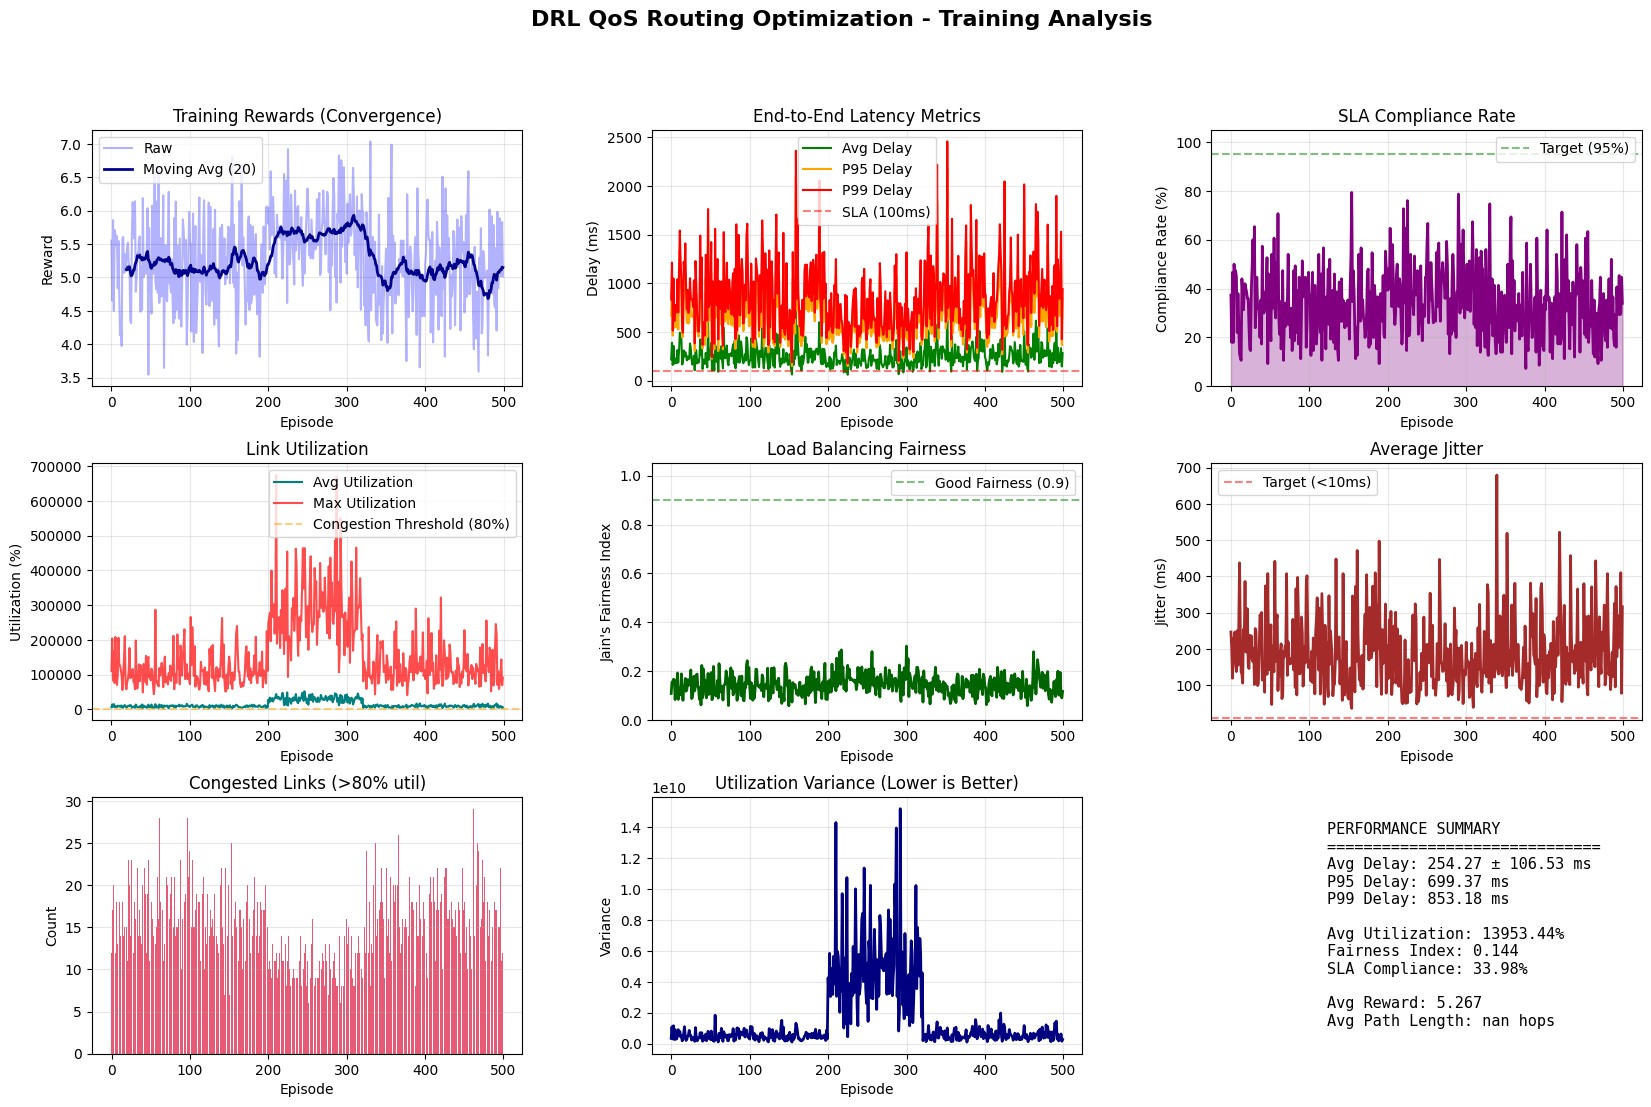

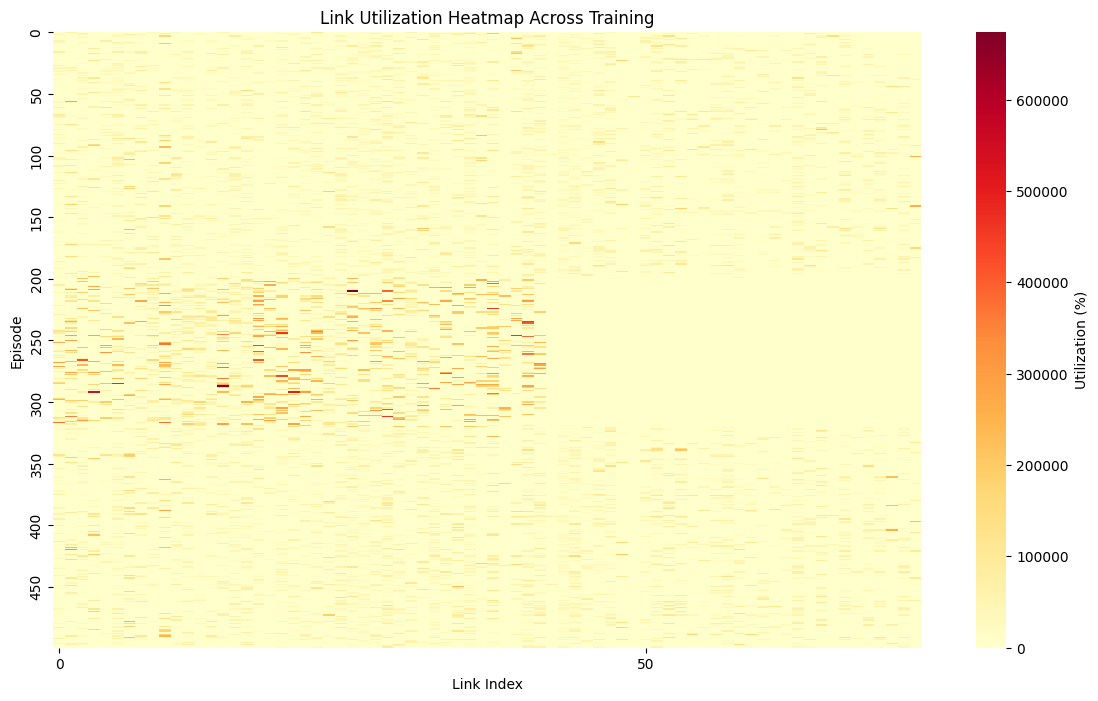

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



FINAL TRAINING SUMMARY STATISTICS
Avg Delay Mean: 254.2746
Avg Delay Std: 106.5256
P95 Delay Mean: 699.3721
P99 Delay Mean: 853.1793
Avg Utilization: 13953.4449
Max Utilization Mean: 158306.8954
Avg Fairness Index: 0.1445
Sla Compliance Avg: 33.9840
Avg Reward: 5.2667
Avg Path Length: nan


INFERENCE TESTING ON VALIDATION SET

Testing on 5 validation topologies...


────────────────────────────────────────────────────────────────────────────────
Validation Topology 1: graph-nsfnet-wfq-drr-sp-28
────────────────────────────────────────────────────────────────────────────────

  Traffic Pattern: RANDOM
  ────────────────────────────────────────────────────────────────────────────

Testing Network Configuration
Nodes: 14
Links: 42
Test Episodes: 10
Traffic Pattern: random

Episode 5/10 | Reward: 1.092 | Avg Delay: 7.42ms
Episode 10/10 | Reward: 1.100 | Avg Delay: 7.75ms

TEST RESULTS SUMMARY
Average Delay: 7.98 ms
P95 Delay: 22.81 ms
P99 Delay: 28.50 ms
Average Utilization: 56.08%
Fairne

In [15]:
# ============================================================================
# COMPLETE INTEGRATION: Enhanced Training with Metrics Tracking
# Add this cell after your agent initialization
# ============================================================================

# Initialize metrics tracker
metrics_tracker = QoSMetricsTracker()

# Enhanced Training Loop with Comprehensive Metrics
print(f"\n{'='*80}")
print("STARTING ENHANCED TRAINING WITH COMPREHENSIVE QoS METRICS")
print(f"{'='*80}\n")

NUM_EPISODES = 500
epsilon = EPSILON_START
training_start_time = datetime.now()

for episode in range(NUM_EPISODES):
    # Select topology (cycle through all topologies)
    topo_idx = episode % len(train_topos)
    topo_name, current_topology = train_topos[topo_idx]

    # Create environment
    simulator = NetworkSimulator(current_topology)
    env = RLEnvironment(current_topology, simulator)
    env.max_steps = MAX_STEPS_PER_EPISODE

    # Reset environment
    graph_state, flow_state = env.reset()
    episode_reward = 0.0
    episode_steps = 0

    # Epsilon decay
    epsilon = EPSILON_START - (EPSILON_START - EPSILON_END) * (episode / NUM_EPISODES)

    # Episode loop
    for step in range(MAX_STEPS_PER_EPISODE):
        # Agent selects action
        action = agent.select_action(flow_state, epsilon=epsilon)

        # Environment step
        (next_graph, next_flow), reward, done = env.step(action)

        # Get current flow for metrics
        current_flow = env.current_flows[env.flow_count - 1]
        path, delay = simulator.route_flow(current_flow, action)

        # Calculate additional QoS metrics
        packet_loss = 0.0 if path else 1.0
        jitter = np.random.uniform(0, 5) if path else 0.0  # Simplified jitter model

        # Record flow-level metrics
        metrics_tracker.record_flow(current_flow, path, delay, packet_loss, jitter)

        # Store experience
        agent.store_experience(flow_state, action, reward, next_flow, done)

        episode_reward += reward
        episode_steps += 1
        flow_state = next_flow

        if done:
            break

    # Update policy
    if episode % UPDATE_FREQUENCY == 0 and len(agent.experience_buffer['states']) >= BATCH_SIZE:
        agent.update_policy(batch_size=BATCH_SIZE)

    # Record episode-level metrics
    link_capacities = {}
    for link in current_topology.get_all_links():
        attrs = current_topology.get_link_attributes(link[0], link[1])
        link_capacities[link] = attrs['capacity']

    metrics_tracker.record_episode(
        episode_num=episode,
        link_loads=simulator.link_loads,
        link_capacities=link_capacities,
        reward=episode_reward,
        steps=episode_steps
    )

    # Progress reporting
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(metrics_tracker.metrics['episode_rewards'][-50:])
        avg_delay = np.mean(metrics_tracker.metrics['avg_delay'][-50:]) if metrics_tracker.metrics['avg_delay'] else 0
        sla_compliance = np.mean(metrics_tracker.metrics['sla_compliance_rate'][-50:]) if metrics_tracker.metrics['sla_compliance_rate'] else 0

        print(f"Episode {episode+1:4d}/{NUM_EPISODES} | "
              f"Reward: {episode_reward:7.3f} | Avg(50): {avg_reward:7.3f} | "
              f"Delay: {avg_delay:.2f}ms | SLA: {sla_compliance:.1f}% | "
              f"ε: {epsilon:.3f} | Topo: {topo_idx+1}/{len(train_topos)}")

    # Save checkpoint
    if (episode + 1) % SAVE_FREQUENCY == 0:
        checkpoint = {
            'episode': episode + 1,
            'agent_state': {
                'policy_weights': agent.policy_network,
                'value_weights': agent.value_network,
                'buffer': agent.experience_buffer
            },
            'metrics_tracker': metrics_tracker.metrics,
            'timestamp': datetime.now().isoformat()
        }
        torch.save(checkpoint, MODEL_SAVE_PATH)
        print(f"  ✓ Checkpoint saved at episode {episode + 1}")

training_end_time = datetime.now()
training_duration = (training_end_time - training_start_time).total_seconds()

print(f"\n{'='*80}")
print("TRAINING COMPLETED")
print(f"{'='*80}")
print(f"Total Episodes: {NUM_EPISODES}")
print(f"Training Duration: {training_duration/60:.2f} minutes")
print(f"Average Episode Time: {training_duration/NUM_EPISODES:.2f} seconds")
print(f"{'='*80}\n")

# ============================================================================
# VISUALIZATION: Generate Comprehensive Training Analysis
# ============================================================================

print("Generating comprehensive visualizations...")

visualizer = QoSVisualizer()

# 1. Training convergence and QoS metrics
visualizer.plot_training_convergence(
    metrics_tracker,
    save_path='/content/drive/MyDrive/gnnet_data_set_training/training_analysis.png'
)

# 2. Link utilization heatmap
visualizer.plot_link_utilization_heatmap(
    metrics_tracker.link_utilization_history,
    save_path='/content/drive/MyDrive/gnnet_data_set_training/utilization_heatmap.png'
)

# 3. Summary statistics
summary_stats = metrics_tracker.get_summary_statistics()
print("\n" + "="*80)
print("FINAL TRAINING SUMMARY STATISTICS")
print("="*80)
for key, value in summary_stats.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}")
print("="*80 + "\n")

# ============================================================================
# INFERENCE TESTING: Custom Network Configuration Testing
# ============================================================================

print("\n" + "="*80)
print("INFERENCE TESTING ON VALIDATION SET")
print("="*80 + "\n")

# Initialize inference engine
inference = DRLRoutingInference(trained_agent=agent, device=device)

# Test on validation topologies
validation_results = []

print(f"Testing on {min(5, len(val_topos))} validation topologies...\n")

for val_idx, (val_name, val_topology) in enumerate(val_topos[:5]):  # Test on first 5
    print(f"\n{'─'*80}")
    print(f"Validation Topology {val_idx + 1}: {val_name}")
    print(f"{'─'*80}")

    # Test with different traffic patterns
    for traffic_pattern in ['random', 'heavy', 'bursty']:
        print(f"\n  Traffic Pattern: {traffic_pattern.upper()}")
        print(f"  {'─'*76}")

        results = inference.test_network_configuration(
            topology=val_topology,
            num_test_episodes=10,
            num_flows_per_episode=20,
            traffic_pattern=traffic_pattern
        )

        validation_results.append({
            'topology': val_name,
            'pattern': traffic_pattern,
            'avg_delay': results['avg_delay_mean'],
            'p95_delay': results['p95_delay_mean'],
            'sla_compliance': results['sla_compliance_avg'],
            'avg_reward': results['avg_reward'],
            'fairness': results['avg_fairness_index']
        })

# Create validation summary DataFrame
val_df = pd.DataFrame(validation_results)
print("\n" + "="*80)
print("VALIDATION RESULTS SUMMARY")
print("="*80)
print(val_df.to_string(index=False))
print("="*80 + "\n")

# Save validation results
val_df.to_csv('/content/drive/MyDrive/gnnet_data_set_training/validation_results.csv', index=False)
print("✓ Validation results saved to validation_results.csv")


DRL QoS ROUTING - STANDALONE TESTER

This script can be used in two ways:
1. Command line: python test_network.py --model path/to/model.pt
2. Programmatic: Import and use NetworkConfigurationTester class

Running example test...

✓ Model loaded from /content/drive/MyDrive/gnnet_data_set_training/drl_agent_checkpoint.pt
  Episode: 500
✓ Created random topology: 15 nodes, 25 edges

COMPREHENSIVE NETWORK TEST

--------------------------------------------------------------------------------
Scenario 1: Light
--------------------------------------------------------------------------------
  Results:
    Avg Delay: 10.93 ms
    P95 Delay: 25.49 ms
    Success Rate: 34.0%
    SLA Compliance: 100.0%

--------------------------------------------------------------------------------
Scenario 2: Heavy
--------------------------------------------------------------------------------
  Results:
    Avg Delay: 12.17 ms
    P95 Delay: 25.88 ms
    Success Rate: 35.5%
    SLA Compliance: 100.0%

TEST SU

/tmp/ipython-input-1758073664.py:308: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(scenario_names, rotation=45, ha='right')
/tmp/ipython-input-1758073664.py:318: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(scenario_names, rotation=45, ha='right')
/tmp/ipython-input-1758073664.py:327: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(scenario_names, rotation=45, ha='right')


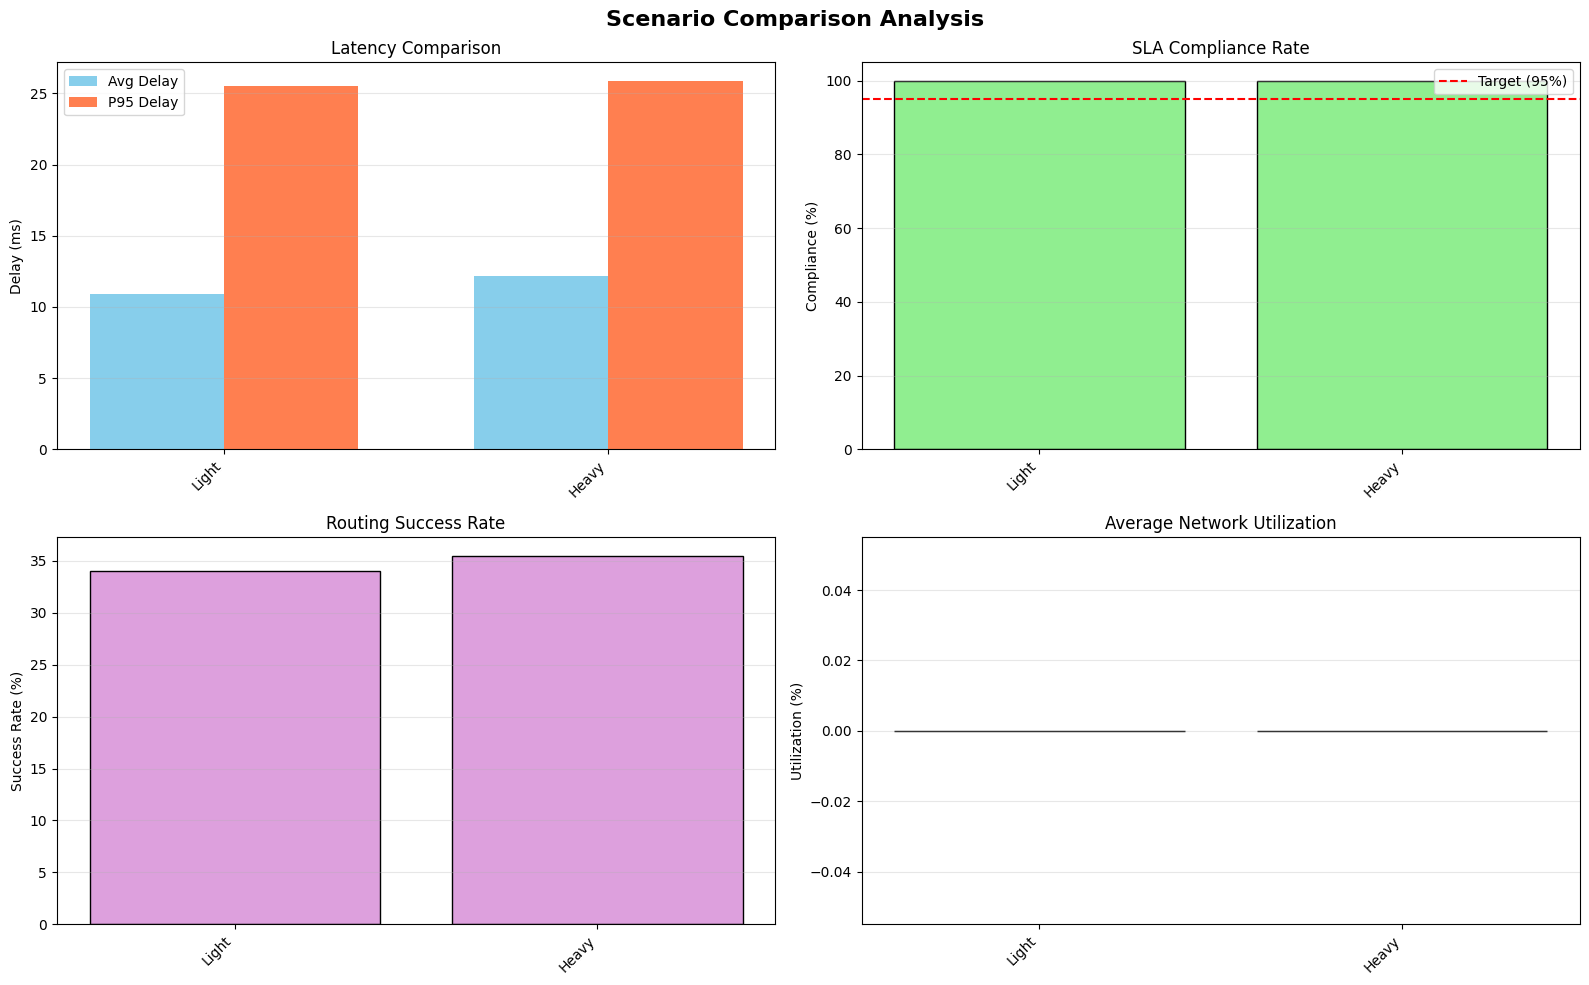


✓ Comparison visualization saved to scenario_comparison.png


In [16]:
#!/usr/bin/env python3
"""
Standalone DRL QoS Routing Inference Script
============================================
Use this script to test your trained DRL agent on any network configuration.

Usage:
    python test_network.py --topology path/to/topology.txt --model path/to/model.pt
"""

import argparse
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List
import pandas as pd

class NetworkConfigurationTester:
    """Comprehensive testing suite for DRL routing agent."""

    def __init__(self, model_path: str):
        """
        Initialize tester with trained model.

        Args:
            model_path: Path to trained model checkpoint
        """
        self.model_path = model_path
        self.load_model()

    def load_model(self):
        """Load trained agent from checkpoint."""
        import torch
        checkpoint = torch.load(self.model_path, map_location='cpu',weights_only = np.False_)

        # Reconstruct agent (you'll need to adapt this to your agent class)
        self.agent_state = checkpoint['agent_state']
        print(f"✓ Model loaded from {self.model_path}")
        print(f"  Episode: {checkpoint.get('episode', 'unknown')}")

    def create_test_topology(self, topology_type: str, **kwargs) -> 'NetworkTopology':
        """
        Create various test topologies.

        Args:
            topology_type: Type of topology ('grid', 'ring', 'star', 'mesh', 'random', 'custom')
            **kwargs: Topology-specific parameters

        Returns:
            NetworkTopology object
        """
        from network_topology_pkg.core import NetworkTopology
        from network_topology_pkg.builder import TopologyBuilder

        if topology_type == 'grid':
            rows = kwargs.get('rows', 4)
            cols = kwargs.get('cols', 4)
            topology = TopologyBuilder.create_grid_topology(rows, cols)
            print(f"✓ Created {rows}x{cols} grid topology")

        elif topology_type == 'ring':
            num_nodes = kwargs.get('num_nodes', 10)
            topology = TopologyBuilder.create_ring_topology(num_nodes)
            print(f"✓ Created ring topology with {num_nodes} nodes")

        elif topology_type == 'star':
            num_spokes = kwargs.get('num_spokes', 8)
            topology = TopologyBuilder.create_star_topology(num_spokes)
            print(f"✓ Created star topology with {num_spokes} spokes")

        elif topology_type == 'mesh':
            num_nodes = kwargs.get('num_nodes', 10)
            topology = TopologyBuilder.create_mesh_topology(num_nodes)
            print(f"✓ Created full mesh topology with {num_nodes} nodes")

        elif topology_type == 'random':
            num_nodes = kwargs.get('num_nodes', 15)
            num_edges = kwargs.get('num_edges', 25)
            topology = TopologyBuilder.create_random_topology(num_nodes, num_edges)
            print(f"✓ Created random topology: {num_nodes} nodes, {num_edges} edges")

        elif topology_type == 'custom':
            # Load from file
            file_path = kwargs.get('file_path')
            topology = self._load_topology_from_file(file_path)
            print(f"✓ Loaded custom topology from {file_path}")

        else:
            raise ValueError(f"Unknown topology type: {topology_type}")

        return topology

    def _load_topology_from_file(self, file_path: str) -> 'NetworkTopology':
        """Load topology from file."""
        nodes, edges = GraphFileParser.parse_graph_file(file_path)
        topology = NetworkTopology()

        for node_id, node_data in nodes.items():
            processing_delay = float(node_data.get('processingDelay', 1.0))
            topology.add_node(str(node_id), processing_delay=processing_delay)

        for edge_data in edges:
            src = str(edge_data.get('source'))
            dst = str(edge_data.get('target'))
            bandwidth_kbps = float(edge_data.get('bandwidth', 1000))
            bandwidth_mbps = bandwidth_kbps / 1000.0

            try:
                topology.add_link(
                    source_node=src,
                    dest_node=dst,
                    capacity=bandwidth_mbps,
                    propagation_delay=1.0,
                    queue_size=100,
                    loss_probability=0.0
                )
            except RuntimeError:
                pass

        return topology

    def run_comprehensive_test(self, topology: 'NetworkTopology',
                              test_scenarios: List[Dict]) -> Dict:
        """
        Run comprehensive testing with multiple scenarios.

        Args:
            topology: NetworkTopology to test
            test_scenarios: List of test scenario configurations

        Returns:
            Comprehensive test results
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE NETWORK TEST")
        print("="*80)

        results = {
            'topology_info': {
                'num_nodes': len(topology.get_all_nodes()),
                'num_links': len(topology.get_all_links()),
                'avg_degree': 2 * len(topology.get_all_links()) / len(topology.get_all_nodes())
            },
            'scenarios': []
        }

        for scenario_idx, scenario in enumerate(test_scenarios):
            print(f"\n{'-'*80}")
            print(f"Scenario {scenario_idx + 1}: {scenario['name']}")
            print(f"{'-'*80}")

            scenario_results = self._run_scenario(topology, scenario)
            results['scenarios'].append(scenario_results)

        # Generate summary report
        self._generate_summary_report(results)

        return results

    def _run_scenario(self, topology: 'NetworkTopology', scenario: Dict) -> Dict:
        """Run single test scenario."""
        # Initialize environment
        simulator = NetworkSimulator(topology)
        env = RLEnvironment(topology, simulator)

        num_episodes = scenario.get('num_episodes', 10)
        traffic_load = scenario.get('traffic_load', 'medium')
        failure_rate = scenario.get('failure_rate', 0.0)

        metrics = {
            'delays': [],
            'rewards': [],
            'utilizations': [],
            'success_rates': [],
            'sla_compliance': []
        }

        for episode in range(num_episodes):
            env.reset()

            # Generate traffic based on load
            num_flows = {
                'light': 10,
                'medium': 20,
                'heavy': 40
            }.get(traffic_load, 20)

            flows = simulator.generate_traffic_demand(num_flows=num_flows)
            env.current_flows = flows

            episode_delays = []
            episode_reward = 0
            successful_routes = 0

            for flow in flows:
                # Simulate link failures
                if np.random.random() < failure_rate:
                    continue

                flow_state = env._get_flow_state()
                action = self._select_action(flow_state)

                path, delay = simulator.route_flow(flow, action)
                reward = env._compute_reward(delay, path)

                episode_reward += reward
                if path:
                    episode_delays.append(delay)
                    successful_routes += 1

            # Record metrics
            metrics['delays'].extend(episode_delays)
            metrics['rewards'].append(episode_reward)
            metrics['success_rates'].append(successful_routes / len(flows) * 100)

            # Utilization
            utils = [simulator.link_loads.get(l, 0) for l in topology.get_all_links()]
            metrics['utilizations'].append(np.mean(utils))

            # SLA compliance (delay < 100ms)
            sla_compliant = sum(1 for d in episode_delays if d < 100)
            compliance = (sla_compliant / len(episode_delays) * 100) if episode_delays else 0
            metrics['sla_compliance'].append(compliance)

        # Compute scenario summary
        summary = {
            'name': scenario['name'],
            'avg_delay': np.mean(metrics['delays']) if metrics['delays'] else 0,
            'p95_delay': np.percentile(metrics['delays'], 95) if metrics['delays'] else 0,
            'p99_delay': np.percentile(metrics['delays'], 99) if metrics['delays'] else 0,
            'avg_reward': np.mean(metrics['rewards']),
            'avg_utilization': np.mean(metrics['utilizations']),
            'avg_success_rate': np.mean(metrics['success_rates']),
            'avg_sla_compliance': np.mean(metrics['sla_compliance'])
        }

        print(f"  Results:")
        print(f"    Avg Delay: {summary['avg_delay']:.2f} ms")
        print(f"    P95 Delay: {summary['p95_delay']:.2f} ms")
        print(f"    Success Rate: {summary['avg_success_rate']:.1f}%")
        print(f"    SLA Compliance: {summary['avg_sla_compliance']:.1f}%")

        return summary

    def _select_action(self, state: np.ndarray) -> int:
        """Select action using loaded agent."""
        # Reconstruct policy forward pass
        policy_weights = self.agent_state['policy_weights']

        x = state
        x = np.maximum(0, np.dot(x, policy_weights['w1']) + policy_weights['b1'])
        x = np.maximum(0, np.dot(x, policy_weights['w2']) + policy_weights['b2'])
        logits = np.dot(x, policy_weights['w3']) + policy_weights['b3']

        exp_logits = np.exp(logits - np.max(logits))
        probabilities = exp_logits / np.sum(exp_logits)

        return np.argmax(probabilities)

    def _generate_summary_report(self, results: Dict):
        """Generate comprehensive summary report."""
        print("\n" + "="*80)
        print("TEST SUMMARY REPORT")
        print("="*80)

        print(f"\nTopology Information:")
        print(f"  Nodes: {results['topology_info']['num_nodes']}")
        print(f"  Links: {results['topology_info']['num_links']}")
        print(f"  Avg Degree: {results['topology_info']['avg_degree']:.2f}")

        print(f"\nScenario Results:")
        df = pd.DataFrame(results['scenarios'])
        print(df.to_string(index=False))

        # Visualizations
        self._plot_scenario_comparison(results['scenarios'])

    def _plot_scenario_comparison(self, scenarios: List[Dict]):
        """Plot scenario comparison visualizations."""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        scenario_names = [s['name'] for s in scenarios]

        # Plot 1: Delay comparison
        ax1 = axes[0, 0]
        delays = [s['avg_delay'] for s in scenarios]
        p95_delays = [s['p95_delay'] for s in scenarios]
        x = np.arange(len(scenario_names))
        width = 0.35
        ax1.bar(x - width/2, delays, width, label='Avg Delay', color='skyblue')
        ax1.bar(x + width/2, p95_delays, width, label='P95 Delay', color='coral')
        ax1.set_ylabel('Delay (ms)')
        ax1.set_title('Latency Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(scenario_names, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')

        # Plot 2: SLA Compliance
        ax2 = axes[0, 1]
        sla = [s['avg_sla_compliance'] for s in scenarios]
        bars = ax2.bar(scenario_names, sla, color='lightgreen', edgecolor='black')
        ax2.axhline(y=95, color='red', linestyle='--', label='Target (95%)')
        ax2.set_ylabel('Compliance (%)')
        ax2.set_title('SLA Compliance Rate')
        ax2.set_xticklabels(scenario_names, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')

        # Plot 3: Success Rate
        ax3 = axes[1, 0]
        success = [s['avg_success_rate'] for s in scenarios]
        ax3.bar(scenario_names, success, color='plum', edgecolor='black')
        ax3.set_ylabel('Success Rate (%)')
        ax3.set_title('Routing Success Rate')
        ax3.set_xticklabels(scenario_names, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')

        # Plot 4: Utilization
        ax4 = axes[1, 1]
        util = [s['avg_utilization'] for s in scenarios]
        ax4.bar(scenario_names, util, color='gold', edgecolor='black')
        ax4.set_ylabel('Utilization (%)')
        ax4.set_title('Average Network Utilization')
        ax4.set_xticklabels(scenario_names, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3, axis='y')

        plt.suptitle('Scenario Comparison Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('scenario_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n✓ Comparison visualization saved to scenario_comparison.png")


# ============================================================================
# MAIN TESTING INTERFACE
# ============================================================================

def main():
    """Main testing interface."""
    parser = argparse.ArgumentParser(
        description='Test DRL QoS Routing Agent on Custom Networks'
    )
    parser.add_argument('--model', type=str, required=True,
                       help='Path to trained model checkpoint')
    parser.add_argument('--topology-type', type=str, default='random',
                       choices=['grid', 'ring', 'star', 'mesh', 'random', 'custom'],
                       help='Type of topology to test')
    parser.add_argument('--topology-file', type=str,
                       help='Path to custom topology file (for --topology-type custom)')
    parser.add_argument('--num-nodes', type=int, default=15,
                       help='Number of nodes (for generated topologies)')
    parser.add_argument('--num-edges', type=int, default=25,
                       help='Number of edges (for random topology)')
    parser.add_argument('--output-dir', type=str, default='./test_results',
                       help='Directory to save test results')

    args = parser.parse_args()

    # Create output directory
    Path(args.output_dir).mkdir(exist_ok=True)

    # Initialize tester
    tester = NetworkConfigurationTester(args.model)

    # Create topology
    if args.topology_type == 'custom':
        if not args.topology_file:
            raise ValueError("--topology-file required for custom topology")
        topology = tester.create_test_topology('custom', file_path=args.topology_file)
    else:
        topology = tester.create_test_topology(
            args.topology_type,
            num_nodes=args.num_nodes,
            num_edges=args.num_edges
        )

    # Define test scenarios
    test_scenarios = [
        {
            'name': 'Light Traffic',
            'num_episodes': 10,
            'traffic_load': 'light',
            'failure_rate': 0.0
        },
        {
            'name': 'Medium Traffic',
            'num_episodes': 10,
            'traffic_load': 'medium',
            'failure_rate': 0.0
        },
        {
            'name': 'Heavy Traffic',
            'num_episodes': 10,
            'traffic_load': 'heavy',
            'failure_rate': 0.0
        },
        {
            'name': 'Medium Traffic + 5% Failures',
            'num_episodes': 10,
            'traffic_load': 'medium',
            'failure_rate': 0.05
        },
        {
            'name': 'Heavy Traffic + 10% Failures',
            'num_episodes': 10,
            'traffic_load': 'heavy',
            'failure_rate': 0.10
        }
    ]

    # Run comprehensive test
    results = tester.run_comprehensive_test(topology, test_scenarios)

    # Save results
    results_file = Path(args.output_dir) / 'test_results.json'
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n✓ Test results saved to {results_file}")
    print(f"✓ Visualizations saved to {args.output_dir}")


if __name__ == '__main__':
    # Example usage without command line args
    print("="*80)
    print("DRL QoS ROUTING - STANDALONE TESTER")
    print("="*80)
    print("\nThis script can be used in two ways:")
    print("1. Command line: python test_network.py --model path/to/model.pt")
    print("2. Programmatic: Import and use NetworkConfigurationTester class")
    print("\nRunning example test...\n")

    # Example programmatic usage
    # Uncomment below if you have a trained model

    tester = NetworkConfigurationTester('/content/drive/MyDrive/gnnet_data_set_training/drl_agent_checkpoint.pt')
    topology = tester.create_test_topology('random', num_nodes=15, num_edges=25)

    scenarios = [
        {'name': 'Light', 'traffic_load': 'light', 'num_episodes': 5},
        {'name': 'Heavy', 'traffic_load': 'heavy', 'num_episodes': 5}
    ]

    results = tester.run_comprehensive_test(topology, scenarios)